In [53]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import wget
import re
import csv

## Use this to get data sets from Legacy Surveys
### Specifies files from Tractor to download, pulls info on objects, gets fits cutouts from skyviewer using coordinates, writes csv file to have the same format as the training classifications.csv, writes csvfile containing object info from Tractor, returns object dictionaries
### NOTE: The directories 'tractor_folders', 'tractor_fits' and 'fits_cutouts' must exist in the same folder as this notebook to run.

In [54]:
def fluxToMag(f):
    return (-2.5 * (np.log(f)/np.log(10.) - 9))

In [55]:
# t_folder = '000'-'359'
# n_files = int or 'all'
# n_objects = int or 'all'
# min_passes = int

# input above values. downloads files from Tractor, gets ra/dec of objects, downloads fits cutouts of those objects
# using legacysurvey skyviewer. also generates csv file to match "classifications.csv" (from lens challlenge), and a
# csv file containing all the information in the generated object dictionaries
def download_Tractor(csvfile, objectcsvfile, t_folder='000', n_files='all', n_objects='all', min_passes=2):
    # download folder within tractor catalog from nersc portal, get html of folder webpage
    print('downloading Tractor files...')
    t_url = 'http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr5/tractor/{}/'.format(t_folder)
    t_folder = wget.download(t_url, '/Users/mac/Desktop/LBNL/DR5/tractor_folders/')
    wgetfile = open(t_folder)
    wgetdata = wgetfile.read()

    # search html code for filename 
    prog = re.compile('(?<=\.fits">).{21}')
    result = prog.findall(wgetdata)
    if n_files != 'all' and n_files <= len(result): # if n_files exceeds total file amount, just get all
        result = result[:n_files] # specify how many files are opened
    
    # create dictionaries for each object containing image, ra/dec, flux (mag), nobs (exposures)
    objects = [] # list of object dictionaries
    print('creating object dictionaries...')
    for f in result:
        filelink = t_url + f
        t_file = wget.download(filelink, '/Users/mac/Desktop/LBNL/DR5/tractor_fits/')
        filedata = fits.open(t_file)[1].data
        if n_objects == 'all' or n_objects > filedata.shape[0]: # if n_objects exceeds total objects in file, just get all
            n_objects = filedata.shape[0]
        for i in range(n_objects):
            image = 'not cut yet'
            filename = 'not cut yet'
            ra = filedata[i][6]
            dec = filedata[i][7]
            
            flux_g = filedata[i][16]
            mag_g = 0
            if flux_g != 0:
                mag_g = fluxToMag(flux_g)
            nobs_g = filedata[i][46]
                
            flux_r = filedata[i][17]
            mag_r = 0
            if flux_r != 0:
                mag_r = fluxToMag(flux_r)
            nobs_r = filedata[i][47]
                
            flux_z = filedata[i][18]
            mag_z = 0
            if flux_z != 0:
                mag_z = fluxToMag(flux_z)
            nobs_z = filedata[i][48]
            
            object_dict = {'image':image,'filename':'not cut yet','ra':ra,'dec':dec,'flux_g':flux_g,'flux_r':flux_r,'flux_z':flux_z,'mag_g':mag_g,'mag_r':mag_r,'mag_z':mag_z,'nobs_g':nobs_g,'nobs_r':nobs_r,'nobs_z':nobs_z}
            objects.append(object_dict)
            print('\tgetting object at {}{}'.format(object_dict['ra'],object_dict['dec']))
#             print('OBJECT ',i)
#             print(object_dict)
#             print('\n')
#             print(filedata[i])
#             print('\n\n\n\n')
    
    # get fits cutouts from ra/dec and add images to object dictionaries
    print('getting fits cutouts from skyviewer...')
    counter = 0
    for o in objects:
        # url specifies ra/dec as well as size (101), pixscale (0.262 is native) and layer (decals-dr5)
        url = 'http://legacysurvey.org/viewer/fits-cutout?ra={}&dec={}&size=101&layer=decals-dr5&pixscale=0.262&bands=grz'.format(o['ra'], o['dec'])
        filename = wget.download(url, '/Users/mac/Desktop/LBNL/DR5/fits_cutouts/cutout_{:06d}.fits'.format(counter))
        image = fits.open(filename)[0].data
        # add iamge array and filename to dict
        o['image'] = image
        o['filename'] = filename
        counter+=1

    # now create csv file to match fits file images, imitating the lensfinder challenge format
    print('writing classification csv file...')
    myFile = open(csvfile, 'w')  
    with myFile:  
        # NOTE: can't get these to have double quotes (e.g. "ID") in the csv file. can only get none and """ID"""
        # not sure if this will affect how it works (lensfinder challenge csv headers have double quotes)
        myFields = ["ID","is_lens","Einstein_area","numb_pix_lensed_image","flux_lensed_image_in_sigma"]
        writer = csv.DictWriter(myFile, fieldnames=myFields)    
        writer.writeheader()
        counter=0
        for i in range(len(objects)):
            # might want to change the ID for the training process if it makes it easier to iterate
            ID = '{:06d}'.format(counter)
            counter+=1
            writer.writerow({"ID":ID,"is_lens":0,"Einstein_area":'nan',"numb_pix_lensed_image":'nan',"flux_lensed_image_in_sigma":'nan'})

    # write csv file to contain information from object dictionaries
    print('writing object info csv file...')
    oFile = open(objectcsvfile, 'w')
    with oFile:  
        # omitting 'image' bc it's a lot to put in the csv file and we already have it
        oFields = ['filename','ra','dec','flux_g','flux_r','flux_z','mag_g','mag_r','mag_z','nobs_g','nobs_r','nobs_z']
        writer = csv.DictWriter(oFile, fieldnames=oFields)    
        writer.writeheader()
        for o in objects:
            writer.writerow({'filename':o['filename'],'ra':o['ra'],'dec':o['dec'],'flux_g':o['flux_g'],'flux_r':o['flux_r'],'flux_z':o['flux_z'],'mag_g':o['mag_g'],'mag_r':o['mag_r'],'mag_z':o['mag_z'],'nobs_g':o['nobs_g'],'nobs_r':o['nobs_r'],'nobs_z':o['nobs_z']})
    
    print('done.')
    return objects

In [56]:
test = download_Tractor(csvfile='class_test.csv', objectcsvfile='objectinfo.csv', n_files=3, n_objects=3)

downloading Tractor files...
creating object dictionaries...
	getting object at 0.05271184352220376-0.3626974389198713
	getting object at 0.03707065549610352-0.3570023769313365
	getting object at 0.029117297411665535-0.3804150862784694
	getting object at 0.018090485071024235-0.6281124559696782
	getting object at 0.020066952490858003-0.6289566721303896
	getting object at 0.01691817250169057-0.6262197946587525
	getting object at 0.17229437507889234-0.8756179516939229
	getting object at 0.17146438705401124-0.8776091071103577
	getting object at 0.05754670211717804-0.8758801598433105
getting fits cutouts from skyviewer...
writing classification csv file...
writing object info csv file...
done.


In [ ]:
# this function is for Chris to use on CMU DeepLens

# opens csv file made in download_Tractor, also uses object dictionary from the above cell to create an hdf5 file with
# the csv info and image array
def make_hdf5(csvfile, objects, imgs):
    # imgs = number of images to write
    cat = Table.read(csvfile)
    if imgs < len(cat):
        cat= cat[0:imgs]
    ims = np.zeros((imgs, 3, 101, 101)) # 4 -> 3
   
    # Loads the images from object dictionaries (previous cell)
    for o in objects:
        ims[i] = o['image']

    # Concatenate images to catalog
    cat['image'] = ims

    # Export catalog as HDF5 (should probably include path before 'catalogs_')
    cat.write('catalogs_'+str(imgs)+'.hdf5', path='/ground', append=True)

    ###### THIS MAY HAVE TO GO SOMEWHERE ELSE
    from astropy.table import Table
    # Loads the table created in the previous section
    d = Table.read(export_path+'catalogs_'+str(imgs)+'.hdf5', path='/ground')  # Path to be adjusted on your machine
    x = array(d['image']).reshape((-1,3,101,101)) # 4 -> 3
    print x.shape
    y = array(d['is_lens']).reshape((-1,1))
    print y.shape


#### Also, in order to run this code on other computers, tractor_folders/, tractor_fits/, and fits_cutouts/ must be created and their paths added to the notebook

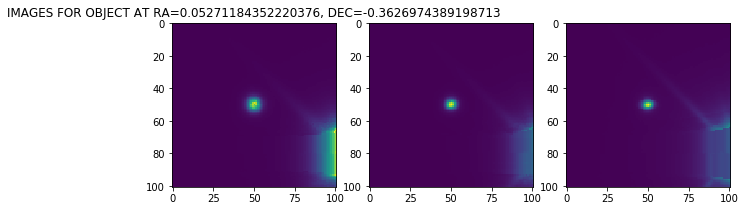

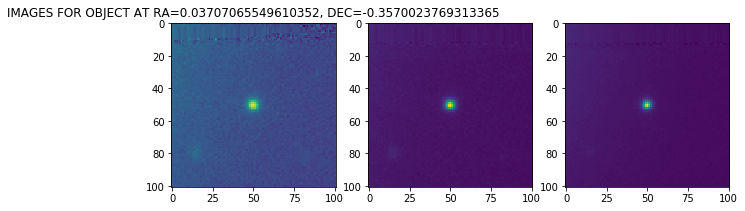

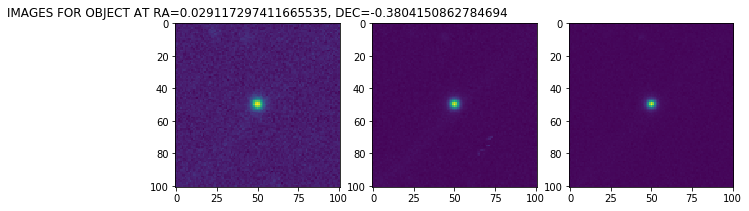

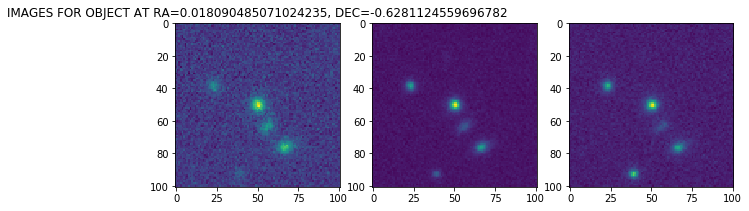

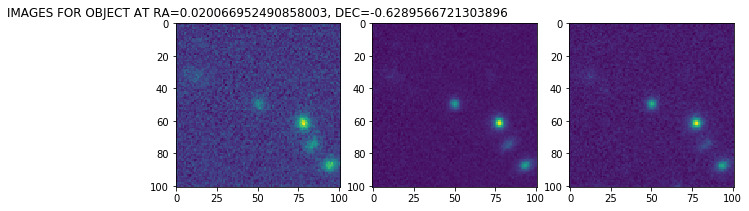

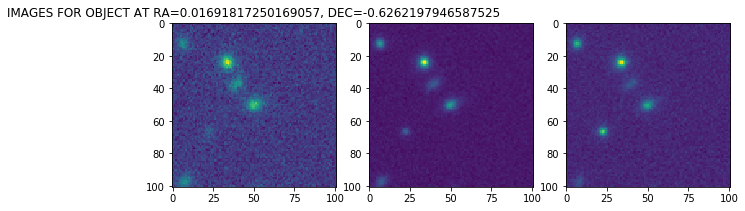

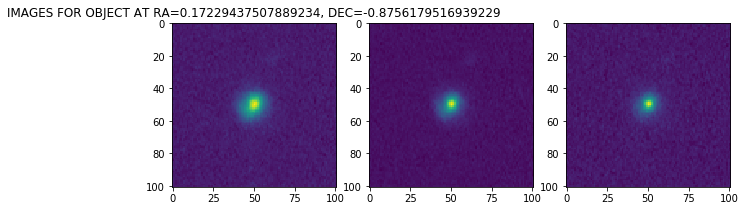

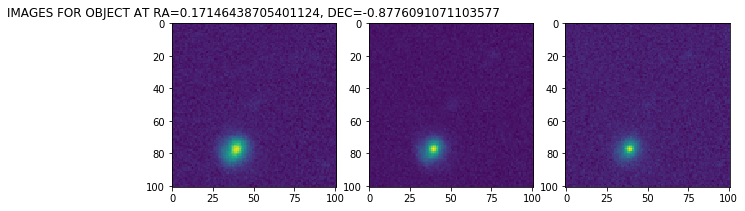

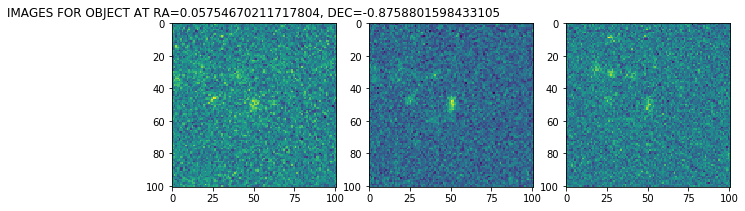

In [43]:
# just plotting images
for i in range(len(test)):
    image = test[i]['image']
    plt.figure(figsize=(10,7))
    plt.subplot(131)
    plt.title('IMAGES FOR OBJECT AT RA={}, DEC={}'.format(test[i]['ra'], test[i]['dec']))
    plt.imshow(image[0,:,:])
    plt.subplot(132)
    plt.imshow(image[1,:,:])
    plt.subplot(133)
    plt.imshow(image[2,:,:])
    
    

In [46]:
image.shape

(3, 101, 101)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


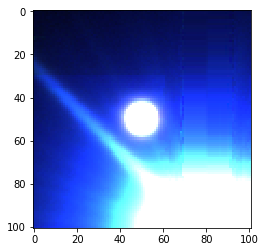

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


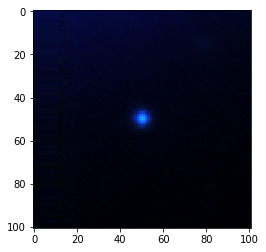

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


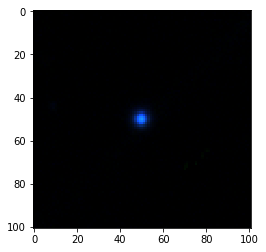

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


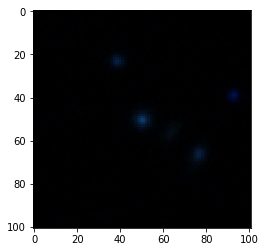

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


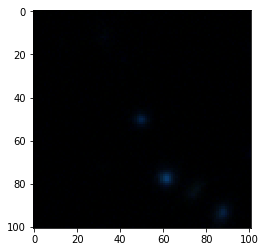

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


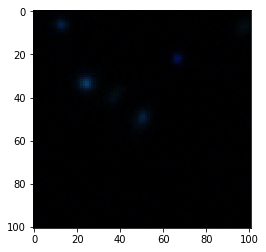

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


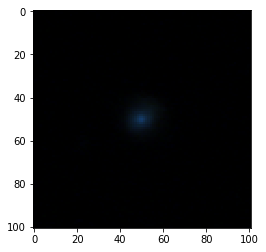

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


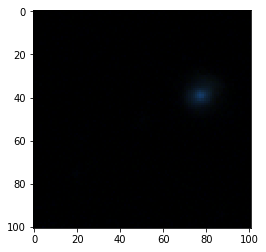

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


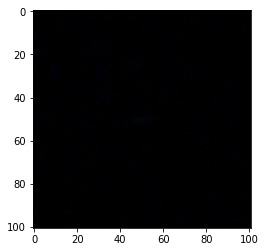

In [45]:
for i in range(len(test)):
    image = test[i]['image']
    plt.imshow(image.T)
    plt.show()